In [ ]:
import numpy as np 
import pandas as pd 
from collections import Counter, defaultdict
#from IPython.display import Image, Audio, display
import pretty_midi
#from music21 import *
from music21 import environment, note, chord, stream, converter, instrument, note, chord
import matplotlib.pyplot as plt 
#from sklearn.model_selection import train_test_split
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import normalize
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.decomposition import PCA
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout
#import tensorflow.keras.backend as K
#from tensorflow.keras.optimizers import Adamax
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from tqdm import tqdm
import sys
import warnings
import glob
import os


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(69)

In [89]:
MIDI_GLOB = "data/**/*.mid"
midi_files = glob.glob(MIDI_GLOB, recursive=True)
print("Archivos MIDI encontrados:", len(midi_files))
# Muestra primeras rutas
for p in midi_files[:5]:
    print(" -", p)

Archivos MIDI encontrados: 295
 - data\albeniz\alb_esp1.mid
 - data\albeniz\alb_esp2.mid
 - data\albeniz\alb_esp3.mid
 - data\albeniz\alb_esp4.mid
 - data\albeniz\alb_esp5.mid


**¿Qué es un archivo MIDI?**
- El formato **MIDI** (**Musical Instrument Digital Interface**) está compuesto por instrucciones o eventos que un dispositivo musical (en este caso un sintetizador) interpreta para producir sonido. Un archivo MIDI es como una **partitura digital** detallada.

**Estructura Básica**

Un archivo MIDI (`.mid`) está compuesto principalmente por:

1.  **Header Track:** Contiene metadatos esenciales como el **formato** del archivo (Tipo 0, 1 o 2), el número de **tracks** que contiene, y el valor de **tiempo** o **división** (pulsos por negra, PPQN).
2.  **Tracks:** Cada pista contiene una secuencia de **mensajes MIDI**. Típicamente, diferentes pistas pueden representar diferentes instrumentos (por ejemplo, Pista 1: Piano, Pista 2: Bajo).

**Mensajes MIDI Clave**

Dentro de cada track, los mensajes se organizan secuencialmente y con marcas de tiempo (**delta-time**), indicando cuándo debe ocurrir un evento. Los mensajes más importantes para la música son:

  * **Note On:** Indica que una nota debe **comenzar** a sonar. Incluye el número de nota (de 0 a 127, donde 60 es C4 o Do central) y la **velocidad** (volumen/intensidad con la que se toca).
  * **Note Off:** Indica que una nota debe **dejar** de sonar.
  * **Program Change:** Cambia el **instrumento** asignado a la pista.
  * **Control Change:** Se usa para modificar parámetros como el **sustain** (pedal), la modulación, etc.
  * **Tempo:** Define la velocidad de la música (`BPM`).

**¿Qué datos utilizaremos?**
Con la librería **`music21`** podemos tratar los archivos **MIDI** como objetos musicales con  sus notas, acordes y partes definidas.

1. Separaremos el objeto `midi` principal en **Partes** (`Part`), donde cada parte corresponde a un **instrumento** diferente (ej. Piano, Guitarra, Flauta). Esto es útil porque el `corpus` a menudo se genera a partir de la secuencia de un instrumento principal. 

2. Iteraremos de forma recursiva sobre la estructura musical para encontrar los elementos útiles de nuestro corpus, es decir las notas y acordes.

### Extraer tokens (notas y acordes) desde un .mid

In [90]:
def extract_corpus_from_midi(midi_path):
    """Devuelve lista de tokens ['C4','E4','C4.E4.G4', ...]"""
    try:
        midi = converter.parse(midi_path)
    except Exception as e:
        print("Error leyendo", midi_path, e)
        return []
    corpus = []
    parts = instrument.partitionByInstrument(midi)
    if parts:
        for part in parts.parts:
            for el in part.recurse():
                if isinstance(el, note.Note):
                    corpus.append(str(el.pitch))
                elif isinstance(el, chord.Chord):
                    corpus.append('.'.join(str(n.pitch) for n in el.notes))
    else:
        for el in midi.flat.notes:
            if isinstance(el, note.Note):
                corpus.append(str(el.pitch))
            elif isinstance(el, chord.Chord):
                corpus.append('.'.join(str(n.pitch) for n in el.notes))
    return corpus

sample = extract_corpus_from_midi(midi_files[0])
print("Tokens extraídos:", len(sample))
print(sample[:80])


Tokens extraídos: 606
['A5', 'A3', 'E6', 'E4', 'E6', 'E4', 'D6.E6', 'D4.E4', 'D6', 'D4', 'C6', 'C4', 'D6', 'D4', 'E6', 'E4', 'F6', 'F4', 'G6', 'G4', 'E6', 'E4', 'F6', 'F4', 'E6', 'E4', 'D6.E6', 'D4.E4', 'D6', 'D4', 'C6', 'C4', 'B-5', 'B-3', 'A2', 'A3', 'E3', 'C#4', 'A3', 'E4', 'C#4', 'A4', 'E4', 'C#5', 'A4', 'E5', 'C#5', 'A4', 'C#4', 'C#5', 'E4', 'E5', 'A4', 'A5', 'C#5', 'C#6', 'E5', 'E6', 'A5', 'C#6', 'E5', 'A5', 'C#5', 'E5', 'A4', 'C#5', 'E4', 'A4', 'C#4', 'E5', 'A4', 'C#5', 'E4', 'A4', 'C#4', 'E4', 'A3', 'C#4', 'A3', 'A3']


Esta parte puede ser un poco extensa, ya que recorreremos todos los archivos para extraer sus tokens:

In [91]:
all_token_lists = []
for f in tqdm(midi_files, desc="Extrayendo tokens"):
    toks = extract_corpus_from_midi(f)
    if len(toks) > 0:
        all_token_lists.append(toks)

print("Canciones con tokens:", len(all_token_lists))

Extrayendo tokens: 100%|██████████| 295/295 [03:30<00:00,  1.40it/s]

Canciones con tokens: 295


In [ ]:
from mido import MidiFile
from IPython.display import display, Audio, HTML

def show_mido_messages(path, n_msgs=30):
    print("Archivo:", path)
    mid = MidiFile(path)
    print("Ticks por beat:", mid.ticks_per_beat)
    print("Número de pistas:", len(mid.tracks))
    for i, track in enumerate(mid.tracks):
        print(f"Track {i}: {track.name}  ({len(track)} mensajes)")
        for msg in track[:n_msgs]:
            print("  ", msg)
        break  # Se muestra solo la primera track

def plot_piano_roll(path, fs=20, figsize=(12,3)):
    pm = pretty_midi.PrettyMIDI(path)
    pr = pm.get_piano_roll(fs=fs)
    plt.figure(figsize=figsize)
    plt.imshow(pr, aspect='auto', origin='lower')
    plt.xlabel("Frames (time)")
    plt.ylabel("Pitch (MIDI)")
    plt.title(os.path.basename(path))
    plt.colorbar(label="Velocity")
    plt.show()

A continuación se muestra la información de la pieza del archivo **alb_esp1.mid**

Archivo: data\albeniz\alb_esp1.mid
Ticks por beat: 480
Número de pistas: 8
Track 0: Espana Op. 165  (570 mensajes)
   MetaMessage('track_name', name='Espana Op. 165', time=0)
   MetaMessage('track_name', name='Prelude', time=0)
   MetaMessage('copyright', text='Copyright © 2001 by Bernd Krueger', time=0)
   MetaMessage('text', text='Isaac Albeniz', time=0)
   MetaMessage('text', text='Andantino', time=0)
   MetaMessage('text', text='Fertiggestellt  27.01.2001\n', time=0)
   MetaMessage('text', text='Update: 18.03.2001\n', time=0)
   MetaMessage('text', text='Normierung: 23.12.2002\n', time=0)
   MetaMessage('text', text='Update am 28.10.2010\n', time=0)
   MetaMessage('text', text='Dauer: 1:36 Minuten\n', time=0)
   MetaMessage('smpte_offset', frame_rate=30, hours=0, minutes=0, seconds=3, frames=0, sub_frames=0, time=0)
   MetaMessage('time_signature', numerator=3, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
   MetaMessage('key_signature', key='F', time=0

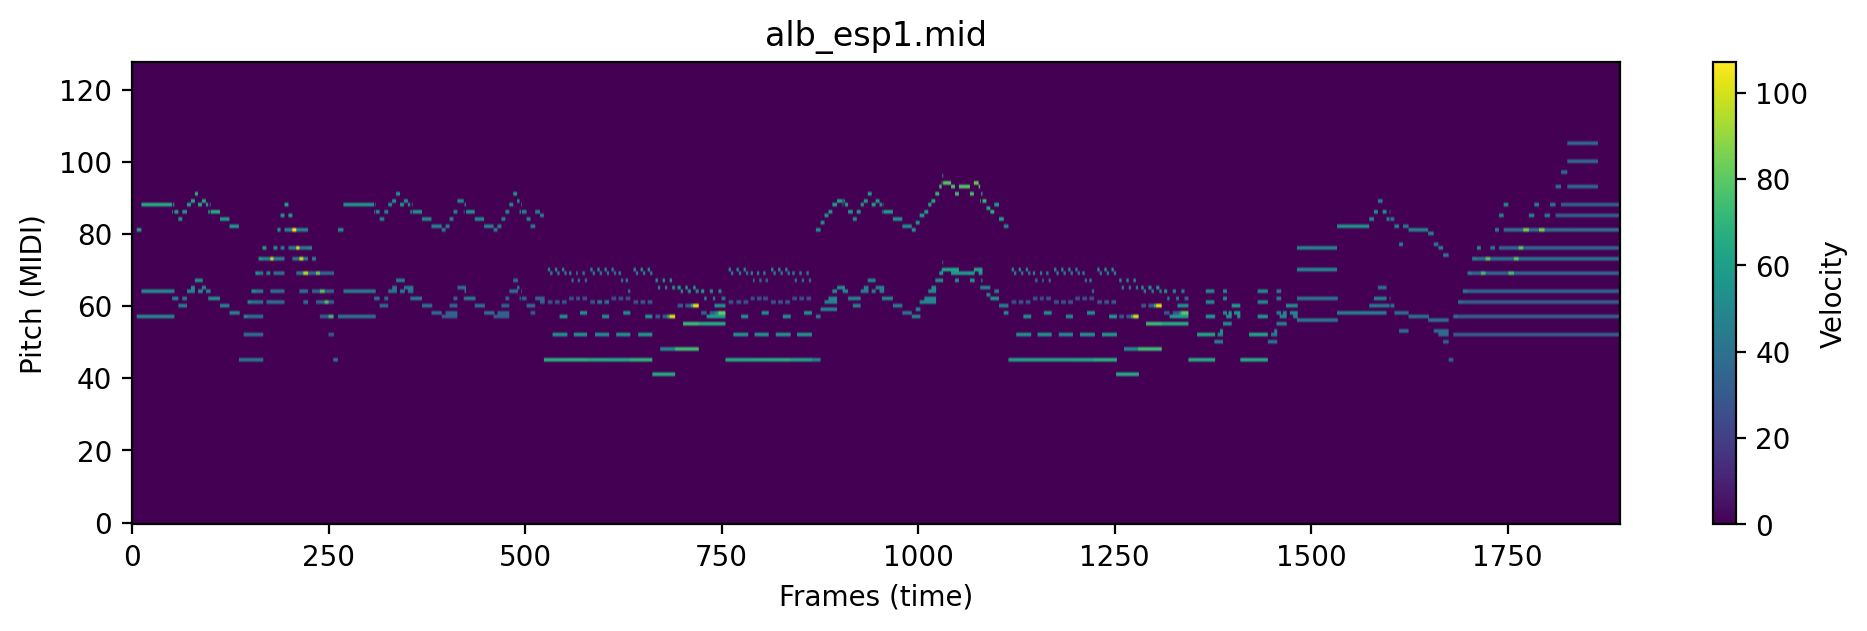

In [93]:
p = midi_files[0]
show_mido_messages(p, n_msgs=20)
plot_piano_roll(p)

A continuación se mostrarán algunas piezas distintas para analizar la variedad y complejidad de ellas:


Archivo 0: alb_esp1.mid - tokens: 606
Primeros 60 tokens: ['A5', 'A3', 'E6', 'E4', 'E6', 'E4', 'D6.E6', 'D4.E4', 'D6', 'D4', 'C6', 'C4', 'D6', 'D4', 'E6', 'E4', 'F6', 'F4', 'G6', 'G4', 'E6', 'E4', 'F6', 'F4', 'E6', 'E4', 'D6.E6', 'D4.E4', 'D6', 'D4', 'C6', 'C4', 'B-5', 'B-3', 'A2', 'A3', 'E3', 'C#4', 'A3', 'E4', 'C#4', 'A4', 'E4', 'C#5', 'A4', 'E5', 'C#5', 'A4', 'C#4', 'C#5', 'E4', 'E5', 'A4', 'A5', 'C#5', 'C#6', 'E5', 'E6', 'A5', 'C#6']


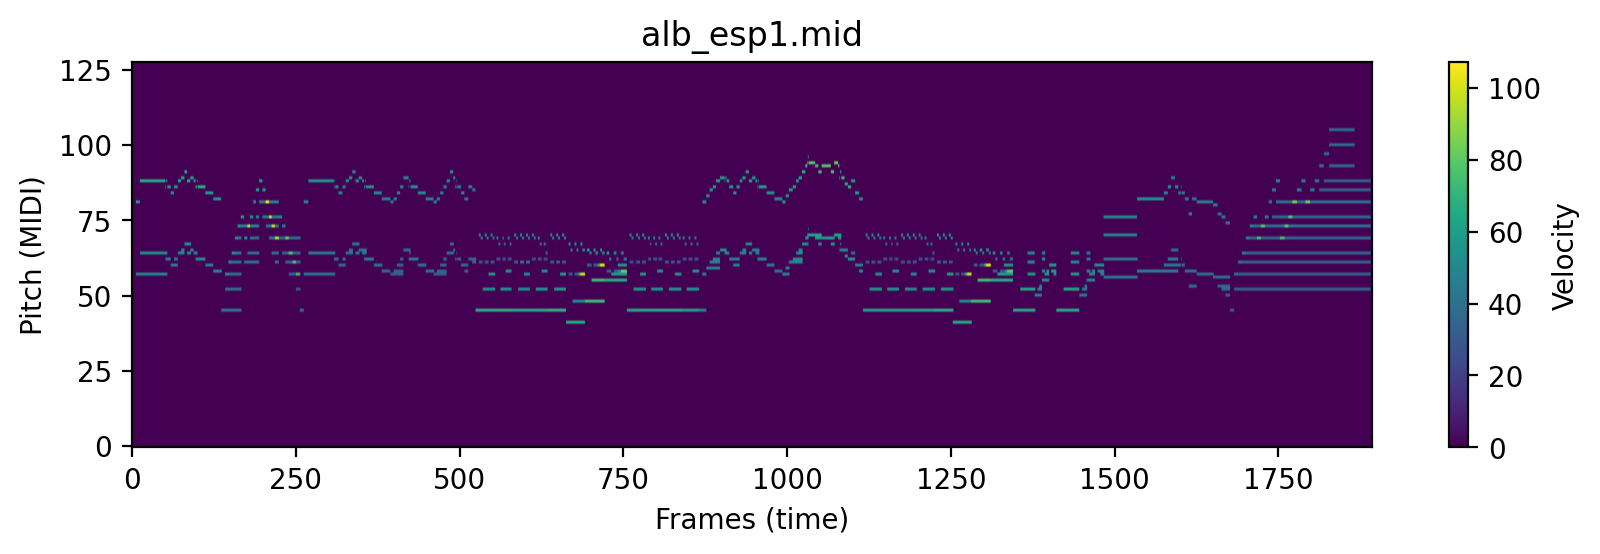


Archivo 1: alb_esp2.mid - tokens: 529
Primeros 60 tokens: ['D2.D3', 'A3', 'A4.F#4.D4', 'A1.A2', 'D2.D3', 'A3', 'D4.F#4.A4', 'A1.A2', 'A3.D4', 'F#4', 'D3', 'F#4', 'F#4.F#4', 'G#3', 'A4', 'G4', 'A3', 'F#4', 'A2', 'A3.D4.F#4.A4', 'D3', 'G#3', 'A3', 'F#4.D5', 'A2', 'E5', 'F#4', 'F#5', 'D3', 'C#5.E5', 'G#3', 'D5', 'A3', 'F4.B4', 'E-3', 'F#4', 'C#4.G4', 'E3', 'G#3', 'A3', 'E4.G4', 'A2', 'F#4.A4', 'G4.B4', 'C#3', 'C#5.A4', 'G#3', 'C#5.E5', 'A3', 'B4.D5', 'A2', 'B4.D5.C#5.E5', 'E3', 'B4.D5', 'C#5.A4', 'G#3', 'A3', 'C#5.E5', 'A2', 'G4.B4']


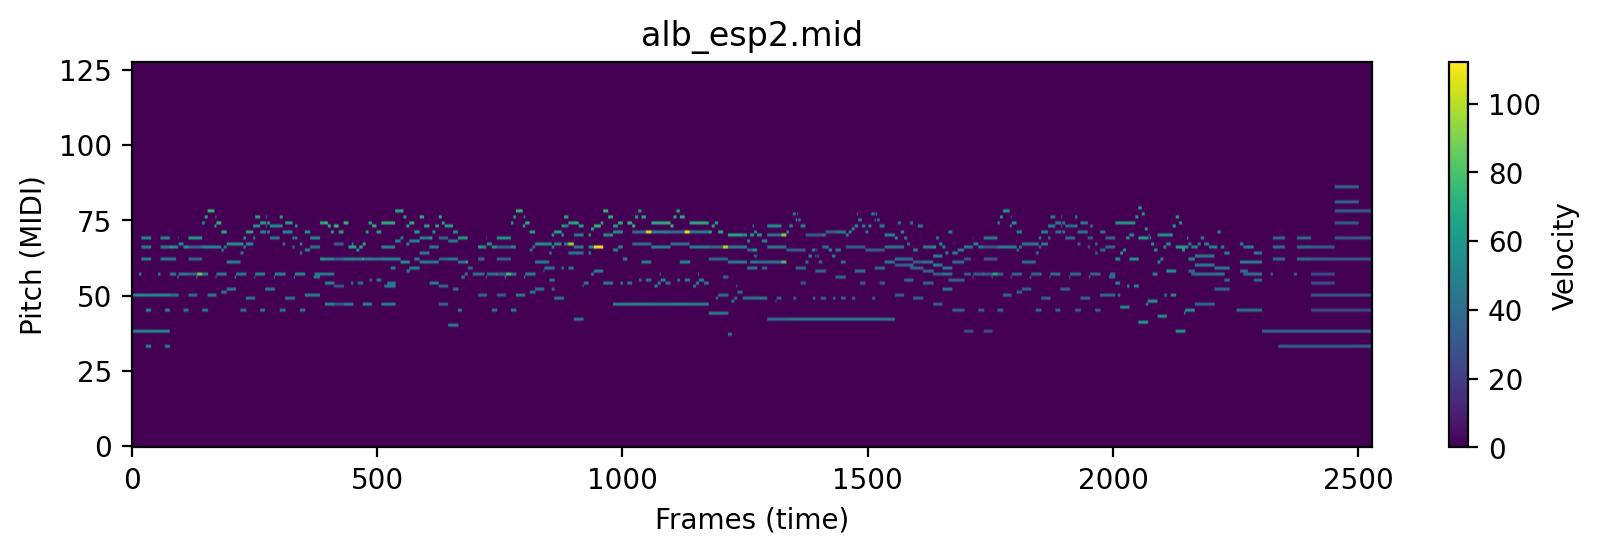


Archivo 2: alb_esp3.mid - tokens: 979
Primeros 60 tokens: ['B4', 'B3', 'E-5', 'E-4', 'F#5', 'F#4', 'E5.F#5', 'E4.F#4', 'E5.C5', 'E4.C4', 'A5', 'A4', 'B4', 'B3', 'E-5', 'E-4', 'F#5', 'F#4', 'E5.F#5', 'E4.F#4', 'E5.C5', 'E4.C4', 'A5', 'A4', 'B3', 'B4', 'F#4', 'E-5', 'F#5', 'E5.F#5', 'F#4', 'E5.C5', 'A5', 'B4', 'F#4', 'E-5', 'F#5', 'E5.F#5', 'F#4', 'E5.C5', 'G4', 'A5', 'F#4', 'B4', 'A4', 'E-5', 'F#5', 'G4.A4', 'G4', 'E5.F#5', 'F#4', 'G4', 'E5.C5', 'A5', 'B4', 'F#4', 'E-5', 'F#5', 'E5.F#5', 'F#4']


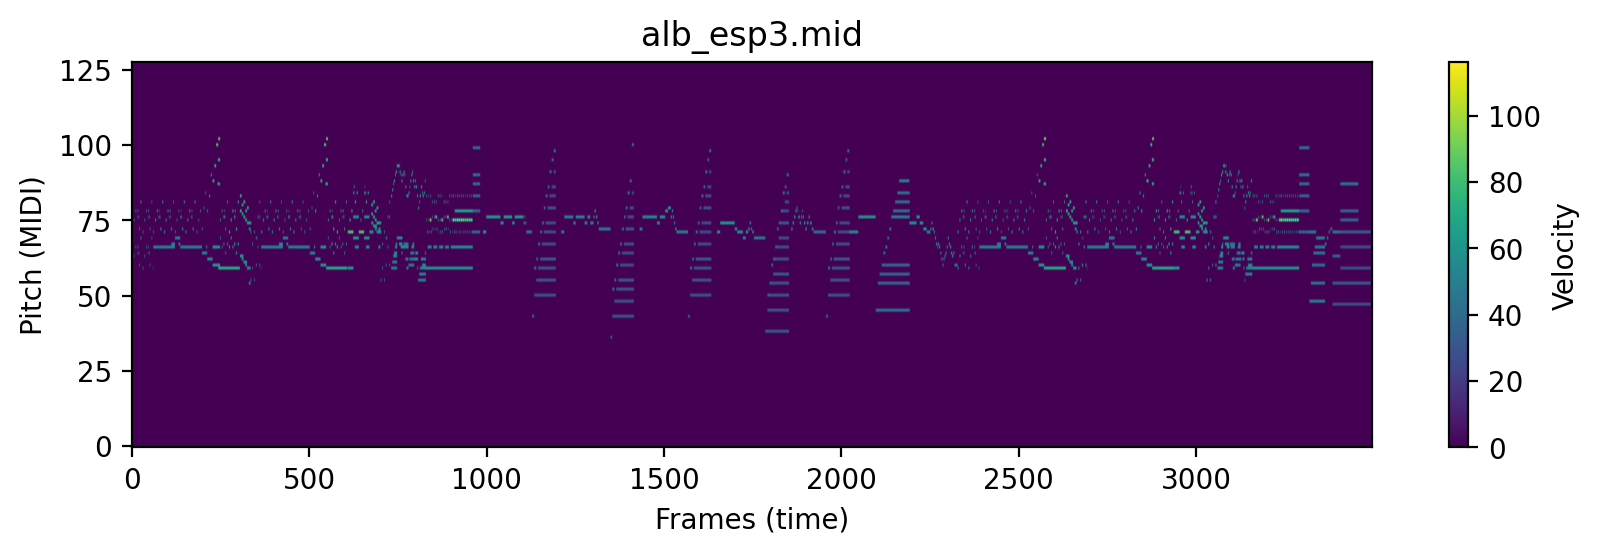

In [94]:
# Cell 4 - Mostrar ejemplos de tokens y cómo representaremos datos
# Tomar 3 ejemplos diferentes para mostrar la variedad
for i, fpath in enumerate(midi_files[:3]):
    toks = extract_corpus_from_midi(fpath)
    print(f"\nArchivo {i}: {os.path.basename(fpath)} - tokens: {len(toks)}")
    print("Primeros 60 tokens:", toks[:60])
    # visualizar piano-roll también
    try:
        plot_piano_roll(fpath, fs=20, figsize=(10,2.5))
    except Exception as e:
        print("No se pudo plotear piano-roll:", e)


Al analizar la estructura de los datos, decidimos utilizar el siguiente formato para el entrenamiento de nuestro modelo generador:
- Nota simple: 'C4'"
- Acorde: 'C4.E4.G4' (notas separadas por '.')

Cada token se mapeará a un entero (vocab) y usaremos ventanas secuenciales para el LSTM.

Pero antes de pasar al modelo, tenemos que normalizar y aumentar nuestros datos ya que como vimos en la extracción de tokens, solo contamos con **295** piezas distintas.

1639.542372881356


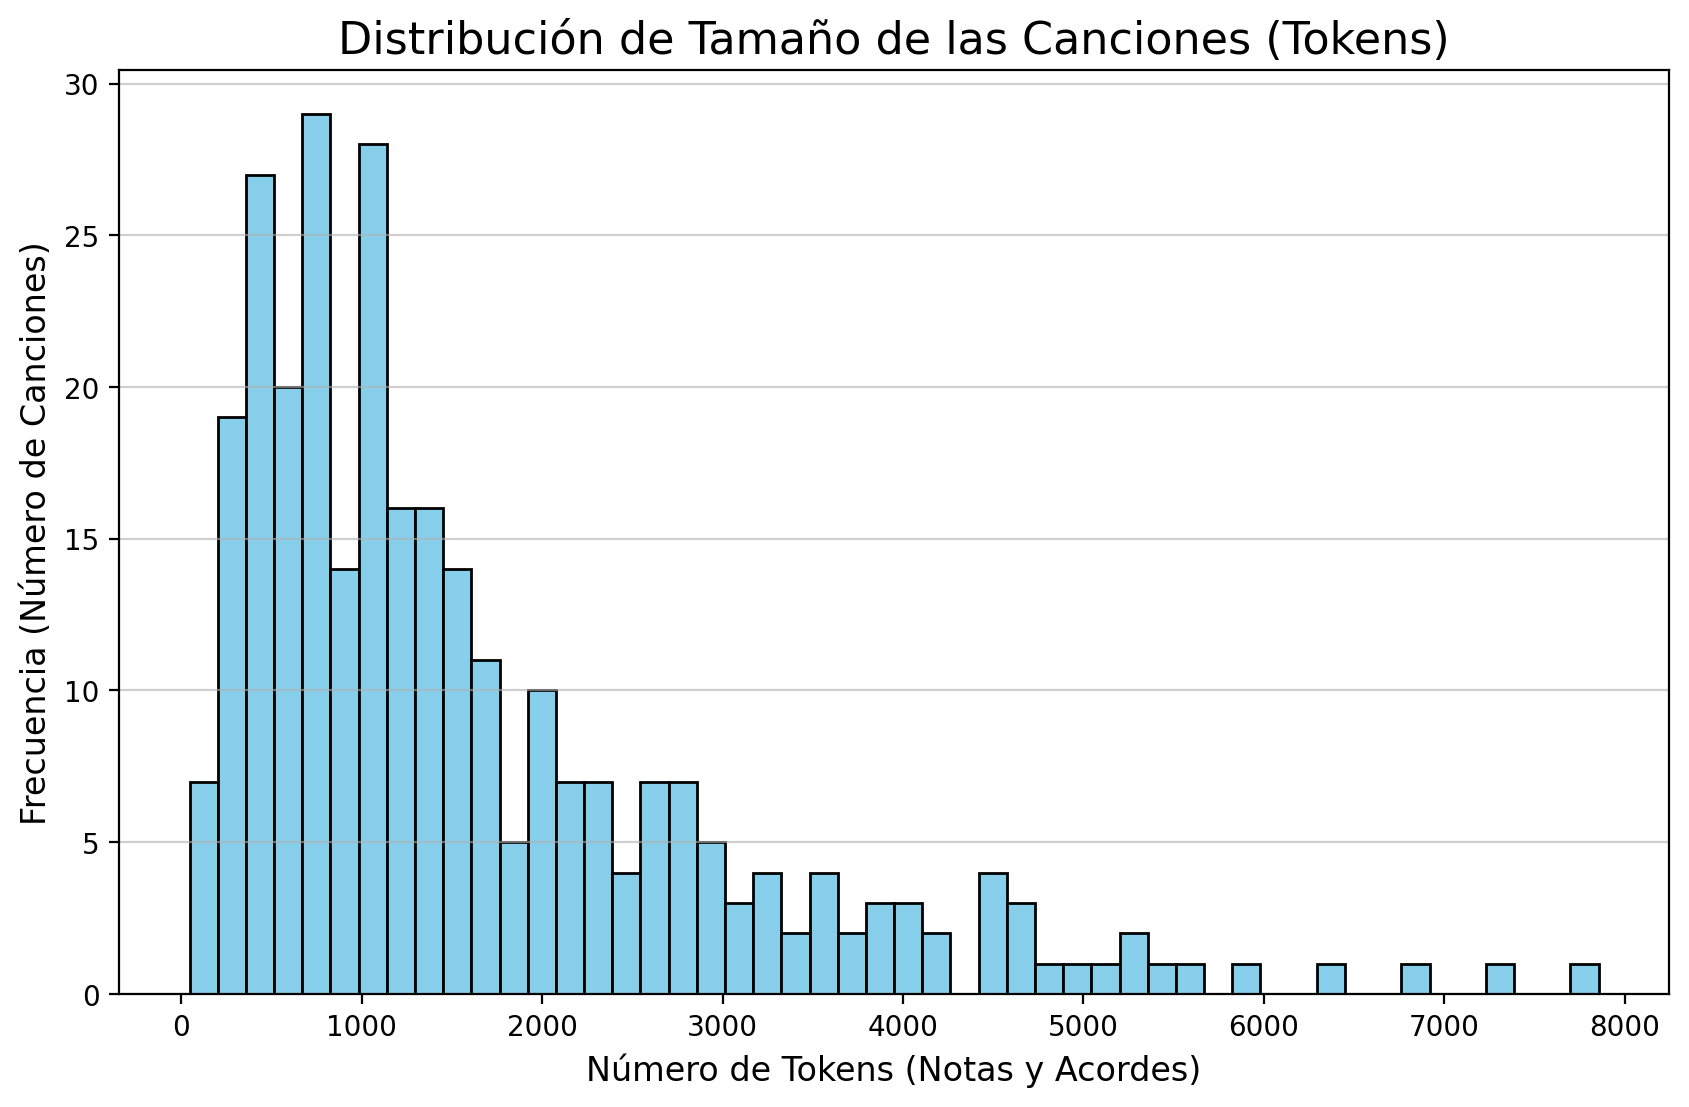

In [105]:
list_lengths = [len(item) for item in all_token_lists]

promedio_numpy = np.mean(list_lengths)
promedio_python = sum(list_lengths) / len(list_lengths)

print(promedio_numpy)

import matplotlib.pyplot as plt

list_lengths = [len(item) for item in all_token_lists]

plt.figure(figsize=(10, 6))
plt.hist(list_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Tamaño de las Canciones (Tokens)', fontsize=16)
plt.xlabel('Número de Tokens (Notas y Acordes)', fontsize=12)
plt.ylabel('Frecuencia (Número de Canciones)', fontsize=12)
plt.grid(axis='y', alpha=0.6)
plt.show()

En el histograma se observa una **distribución Asimétrica** con Cola Larga y una distribución sesgada a la derecha. Esto significa que la mayoría de las canciones son cortas, agrupándose en el rango de 0 a 2,000 tokens. La frecuencia más alta se encuentra entre los 500 y 1,000 tokens, con un pico notable.

Además podemos notar que la media ($\mu = 1639.54$) es significativamente mayor que la moda (el pico de la distribución, que está entre 500 y 1000 tokens). Esto es un indicador directo de la asimetría y significa que existen algunas canciones extremadamente largas que están arrastrando el valor promedio hacia arriba.

#### **¿Cómo afectaría al modelo?**
Si entrenáramos el modelo directamente con las canciones como las tenemos, las piezas más largas dominarían el entrenamiento y requerirían una gran cantidad de memoria.

#### **Nuestra solución**
Proponemos dividir las canciones en segmentos de un tamaño definido, de esa manera solucionaríamos tanto el problema del **volumen** de datos como el de la distribución **sesgada** del largo de las canciones.

Realizamos un análisis de los Pros y Contras de los distintos largos sugeridos:

|Longitud de Segmento|Pros|Contras|
|---|---|---|
|50 | Tendríamos muchos más datos de entrenamiento y capturaría frases muy cortas.|El modelo podría perder el contexto armónico de largo plazo como puede ser una sección musical completa.|
|100 - 150 |Ofrece un mejor **equilibrio**, capturando frases y hasta medio compás de estructura armónica en muchos estilos, mientras sigue generando muchos segmentos.|Genera menos segmentos que 50, y las canciones muy cortas podrían no producir tantos segmentos si el hop es pequeño.|
|200+|Captura un contexto musical amplio.|Si bien aumentaríamos los datos, no sería tan significativo como con los largos anteriores, lo que podría no ser suficiente para el entrenamiento. Aumenta la complejidad y el tiempo de entrenamiento. Además el padding que se agregue a las canciones menores a este valor puede afectar el rendimiento del modelo|

El valor más prometedor parece ser entre 100 y 150, por eficiencia computacional escogimos el valor de **128** (por ser potencia de 2). De igual manera antes de hacer la segmentación, verificamos cuántas secuencias son más cortas de 128 para saber cuanto nos va a afectar el padding posterior.

In [109]:
short_songs_count = sum(1 for length in list_lengths if length < 128)

print(f"Canciones totales: {len(list_lengths)}")
print(f"Canciones más cortas que 128 tokens (serán rellenadas): {short_songs_count}")

if len(list_lengths) > 0:
    percentage = (short_songs_count / len(list_lengths)) * 100
    print(f"Porcentaje de canciones cortas: {percentage:.2f}%")

Canciones totales: 295
Canciones más cortas que 128 tokens (serán rellenadas): 3
Porcentaje de canciones cortas: 1.02%


Cómo únicamente hay 3 canciones más cortas que **128**, podemos decir que **128** es un buen largo para nuestras secuencias de entrenamiento.

### **Data Augmentation**

In [136]:
# 1. construir vocabulario (token -> index)
import json
from collections import Counter

def build_token_mapping(all_token_lists, min_count=1, filename="token2idx.json"):
    """
    Construye el vocabulario (token -> index) y lo guarda en un archivo JSON.
    """
    cnt = Counter()
    for L in all_token_lists:
        cnt.update(L)
    
    tokens = [t for t,c in cnt.items() if c >= min_count]
    tokens = sorted(tokens)
    
    token2idx = {t:i+1 for i,t in enumerate(tokens)}
    token2idx['<UNK>'] = len(token2idx) + 1    
    idx2token = {i:t for t,i in token2idx.items()}    
    try:
        with open(filename, 'w') as f:
            json.dump(token2idx, f, indent=4)
        print(f"Mapeo de tokens guardado en: {filename}")
    except Exception as e:
        print(f"Error al guardar el mapeo en JSON: {e}")
        
    return token2idx, idx2token, cnt

token2idx, idx2token, token_counts = build_token_mapping(all_token_lists, min_count=1)
print("Vocab size:", len(token2idx))
print("Tokens más comunes:", token_counts.most_common(10))

# 2) sliding segments (data augmentation) -> seqs (numéricas)
def sliding_segments(token_list, seg_len=50, hop=5):
    segments = []
    if len(token_list) < seg_len:
        segments.append(token_list[:])
        return segments
    for start in range(0, len(token_list) - seg_len + 1, hop):
        segments.append(token_list[start:start+seg_len])
    if (len(token_list) - seg_len) % hop != 0:
        segments.append(token_list[-seg_len:])
    return segments

def tokens_to_sequence(tokens, token2idx):
    return [token2idx.get(t, token2idx['<UNK>']) for t in tokens]

# Crear seqs numéricas
seg_len = 128; hop = 5
seqs = []
origin_map = [] 
for si, toks in enumerate(all_token_lists):
    segs = sliding_segments(toks, seg_len=seg_len, hop=hop)
    for i, s in enumerate(segs):
        seqs.append(tokens_to_sequence(s, token2idx))
        origin_map.append((si, i*hop))
print(f"Total segmentos extraídos de {len(all_token_lists)} canciones: {len(seqs)}")


Mapeo de tokens guardado en: token2idx.json
Vocab size: 15350
Tokens más comunes: [('C4', 10702), ('D4', 10309), ('G4', 10132), ('C5', 10112), ('D5', 9613), ('E4', 9209), ('G3', 9191), ('A4', 8831), ('F4', 8806), ('B-3', 8341)]
Total segmentos extraídos de 295 canciones: 89618


### **Análisis de los fragmentos**

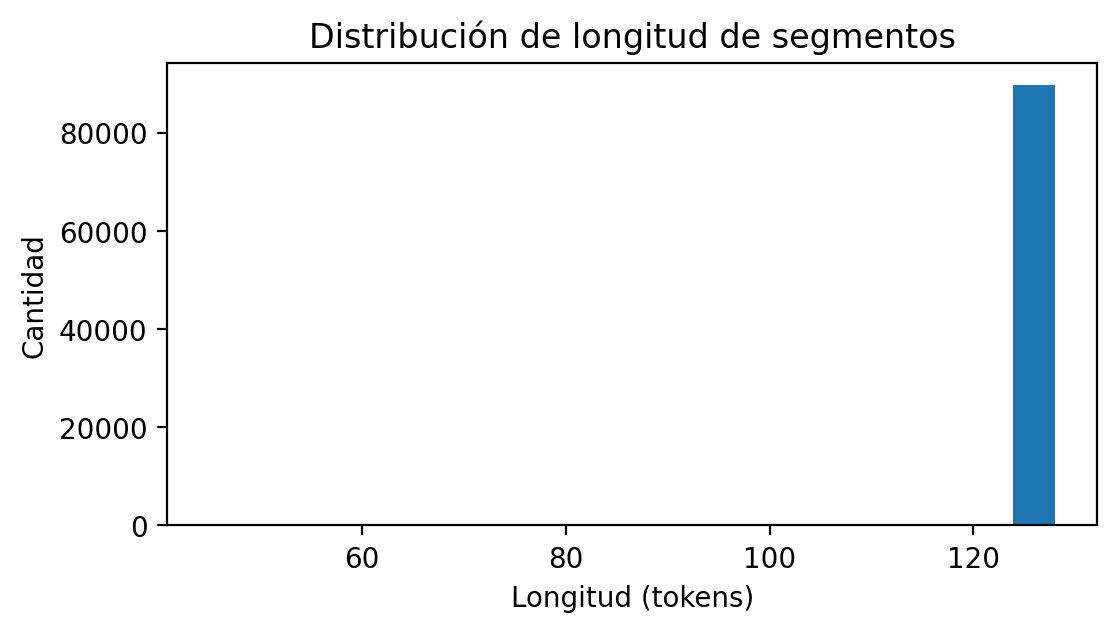

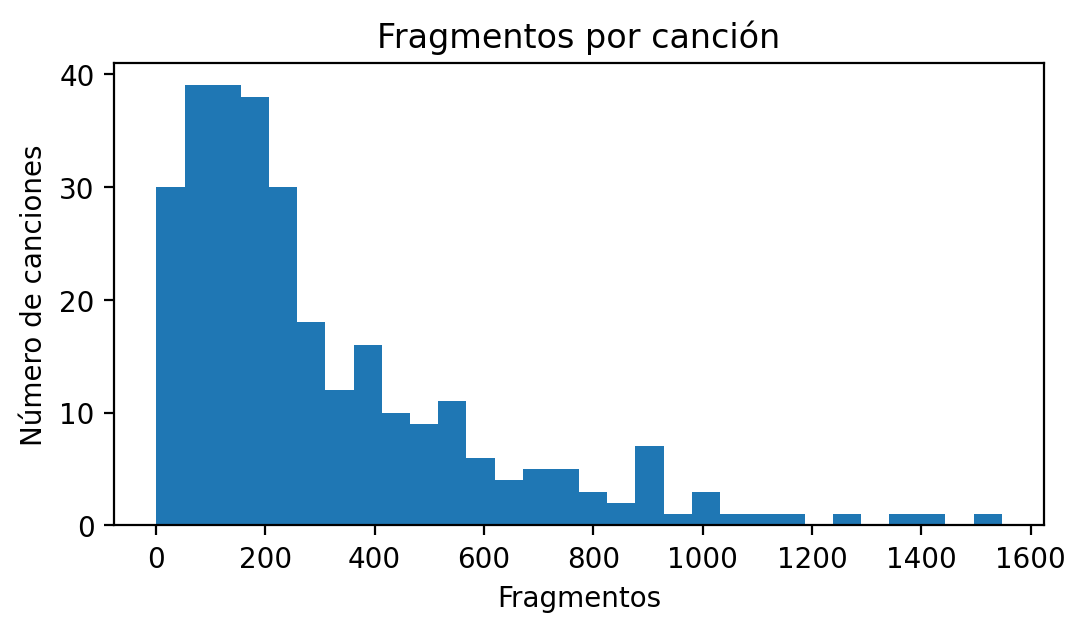

Resumen fragmentos por canción:
 min: 1
 med: 212.0
 mean: 303.78983050847455
 max: 1547
Vocab size: 15350
Ejemplo tokens únicos en primer segmento: ['A5', 'A3', 'E6', 'E4', 'E6', 'E4', 'D6.E6', 'D4.E4', 'D6', 'D4', 'C6', 'C4']


In [ ]:
lens = [len(s) for s in seqs]
plt.figure(figsize=(6,3))
plt.hist(lens, bins=20)
plt.title("Distribución de longitud de segmentos")
plt.xlabel("Longitud (tokens)")
plt.ylabel("Cantidad")
plt.show()

counts_per_song = defaultdict(int)
for (si, _) in origin_map:
    counts_per_song[si] += 1
counts = list(counts_per_song.values())
plt.figure(figsize=(6,3))
plt.hist(counts, bins=30)
plt.title("Fragmentos por canción")
plt.xlabel("Fragmentos")
plt.ylabel("Número de canciones")
plt.show()

print(f"Resumen fragmentos por canción:\n min: {np.min(counts)}\n med: {np.median(counts)}\n mean: {np.mean(counts)}\n max: {np.max(counts)}")
print("Vocab size:", len(token2idx))
print("Ejemplo tokens únicos en primer segmento:", [idx2token[i] for i in seqs[0][:12]])


In [122]:
print(token2idx['<UNK>'])

15350


In [125]:

token_index = token2idx['<UNK>']

all_tokens_flat = [token for seq in seqs for token in seq]
all_tokens_array = np.array(all_tokens_flat)
unk_count_np = np.sum(all_tokens_array == token_index)

print("Anñalisis del token <UNK>:")
print(f"    Conteo: {unk_count_np}")

total_tokens = len(all_tokens_flat)
if total_tokens > 0:
    percentage = (unk_count_np / total_tokens) * 100
    print(f"    Porcentaje: {percentage:.4f}%")

Anñalisis del token <UNK>:
    Conteo: 0
    Porcentaje: 0.0000%


### Análisis del Corpus y la Segmentación

El proceso de extracción de tokens y segmentación ha generado un conjunto de datos robusto y diverso.

| Métrica Clave | Valor |
|---|---|
| **Tamaño Vocabulario** | $15,350$ tokens |
| **Tokens `<UNK>`** | $0$ (0.00%) |
| **Canciones Originales** | $295$ |
| **Segmentos Generados** | $89,618$ |


### 1. Riqueza del Vocabulario y Cobertura

El **tamaño de vocabulario de 15,350** es alto y refleja una gran **diversidad armónica** (incluye muchas combinaciones únicas de notas como acordes). afortunadamente no hay ningún token `<UNK>` por lo que todos los elementos musicales del **corpus** han sido capturados, lo que maximiza la información disponible para el modelo. Los tokens más comunes confirman que la extracción se centra en notas de rango medio (`C4`, `D4`, etc.), típicas de melodías y acompañamientos de piano.

### 2. Éxito del Data Augmentation

La segmentación con un **hop** pequeño transformó $\mathbf{295}$ canciones en **$\mathbf{89,618}$ segmentos**, un aumento masivo de datos que garantiza un entrenamiento más efectivo y evita el sobreajuste.

* **Distribución:** El resumen de fragmentos ($\text{media} \approx 304$ segmentos por canción) indica que la mayoría de los archivos eran lo suficientemente largos para justificar la segmentación.
* **Manejo de Extremos:** Aunque el $\text{mínimo}$ es **$1$ segmento** (para canciones muy cortas), este impacto es marginal. Las canciones cortas se conservan como ejemplos de entrenamiento únicos y serán **rellenadas (*padded*) a $128$**, lo que es preferible a descartarlas o entrenar con secuencias de longitud variable.

En resumen, el **corpus** final está **limpio (0% `<UNK>`)**, es **diversificado** (alto vocabulario) y es **masivo ($\approx 90\text{K}$ segmentos)**, lo que proporciona una base sólida para entrenar una red neuronal eficiente.

---

## Construcción del modelo

Primero construimos X,y para el LSTM

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

SEQ_LEN = seg_len
X = []
y = []

for s in seqs:
    # Se procesa solo  si el segmento tiene el tamaño completo
    if len(s) == SEQ_LEN:
        X.append(s[:-1]) # s[0] a s[126] -> 127 tokens
        
        y.append(s[-1])  # s[127] -> 1 token objetivo


X = np.array(X)
y = np.array(y)
print("Total ejemplos X,y:", X.shape, y.shape) 

VOCAB_SIZE = len(token2idx) + 1  
y_cat = to_categorical(y, num_classes=VOCAB_SIZE)

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.10, random_state=42)
print("Train / Val shapes:", X_train.shape, X_val.shape)

Total ejemplos X,y: (89615, 127) (89615,)
Train / Val shapes: (80653, 127) (8962, 127)


**Construcción del Modelo LSTM**
- Embedding: Reduciendo dimensionalidad para aprender similitudes entre notas y acordes.
- LSTM: Para capturar dependencias temporales
- Dropout: Regularizar el modelo para que no tenga overfitting
- Dense (SoftMax): Pos para que el token con mayor probabilidad sea la nota predicha


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt

# SEQ_LEN = 128 de la celda anterior
SEQ_LEN_INPUT = 128 - 1  # La longitud real de X es (128 - 1) = 127
EMBEDDING_DIM = 128
LSTM_UNITS = 256

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SEQ_LEN_INPUT), 
    
    LSTM(LSTM_UNITS, return_sequences=False),
    Dropout(0.3),
    
    # La capa Dense de salida debe coincidir con el tamaño de y_cat (VOCAB_SIZE)
    Dense(VOCAB_SIZE, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Entrenar**

Aquí se cambia ``"best_model.h5"`` por el nombre deseado para diferencias las versiones de modelo, por default se guardaa en la carpeta raíz. Para usar en la app hay que moverlo a la carpeta [app/models](app\models).

> Se puede actualizar el formato para guardar el modelo y así evitar el warning

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

ckpt = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=128, callbacks=[ckpt, es])


Epoch 1/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.0196 - loss: 6.6967

631/631 ━━━━━━━━━━━━━━━━━━━━ 362s 569ms/step - accuracy: 0.0203 - loss: 6.2543 - val_accuracy: 0.0218 - val_loss: 5.9153
Epoch 2/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.0232 - loss: 5.7895

631/631 ━━━━━━━━━━━━━━━━━━━━ 346s 549ms/step - accuracy: 0.0252 - loss: 5.7655 - val_accuracy: 0.0302 - val_loss: 5.8172
Epoch 3/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.0372 - loss: 5.5345

631/631 ━━━━━━━━━━━━━━━━━━━━ 340s 539ms/step - accuracy: 0.0430 - loss: 5.4965 - val_accuracy: 0.0530 - val_loss: 5.5765
Epoch 4/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.0594 - loss: 5.2146

631/631 ━━━━━━━━━━━━━━━━━━━━ 345s 547ms/step - accuracy: 0.0653 - loss: 5.1799 - val_accuracy: 0.0781 - val_loss: 5.3697
Epoch 5/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.0836 - loss: 4.8677

631/631 ━━━━━━━━━━━━━━━━━━━━ 340s 538ms/step - accuracy: 0.0857 - loss: 4.8743 - val_accuracy: 0.0858 - val_loss: 5.2707
Epoch 6/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.1013 - loss: 4.6030

631/631 ━━━━━━━━━━━━━━━━━━━━ 337s 533ms/step - accuracy: 0.1030 - loss: 4.6155 - val_accuracy: 0.0944 - val_loss: 5.2291
Epoch 7/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.1220 - loss: 4.3486

631/631 ━━━━━━━━━━━━━━━━━━━━ 337s 534ms/step - accuracy: 0.1209 - loss: 4.3670 - val_accuracy: 0.1041 - val_loss: 5.2050
Epoch 8/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.1416 - loss: 4.0960

631/631 ━━━━━━━━━━━━━━━━━━━━ 335s 531ms/step - accuracy: 0.1396 - loss: 4.1310 - val_accuracy: 0.1154 - val_loss: 5.1963
Epoch 9/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 332s 527ms/step - accuracy: 0.1645 - loss: 3.8969 - val_accuracy: 0.1186 - val_loss: 5.1965
Epoch 10/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 336s 532ms/step - accuracy: 0.1930 - loss: 3.6759 - val_accuracy: 0.1255 - val_loss: 5.2150
Epoch 11/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 340s 539ms/step - accuracy: 0.2193 - loss: 3.4693 - val_accuracy: 0.1221 - val_loss: 5.2396
Epoch 12/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 335s 531ms/step - accuracy: 0.2493 - loss: 3.2815 - val_accuracy: 0.1301 - val_loss: 5.2600
Epoch 13/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 336s 532ms/step - accuracy: 0.2788 - loss: 3.1113 - val_accuracy: 0.1302 - val_loss: 5.3158


**Evaluación y Gráficas**

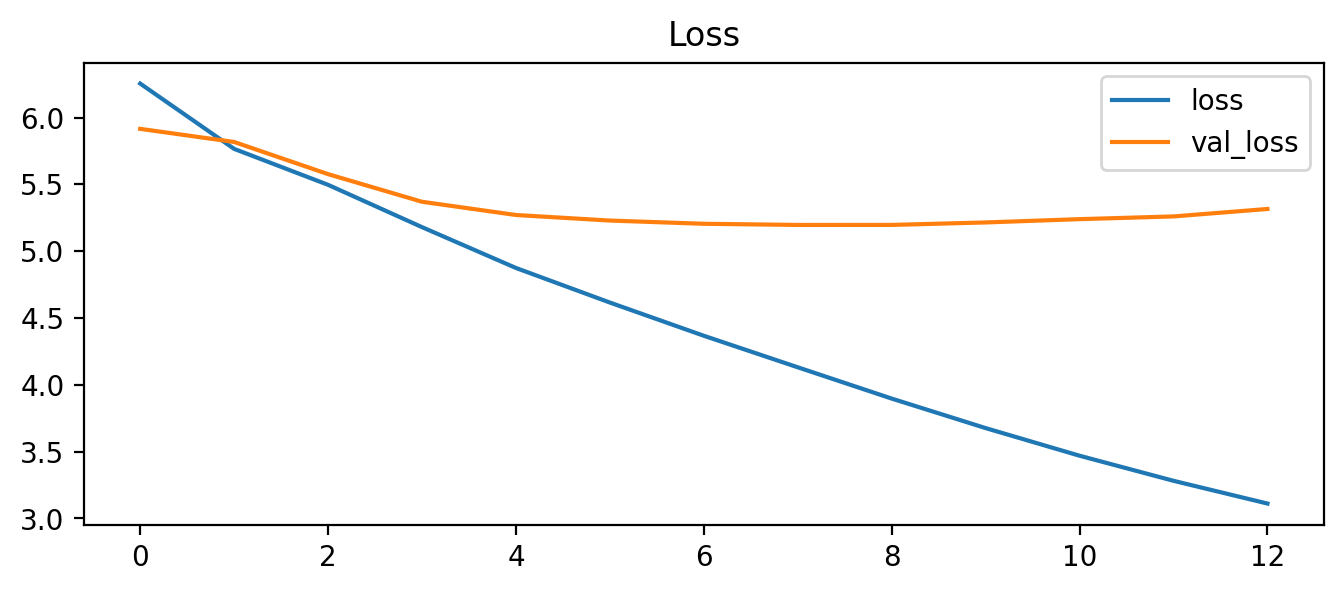

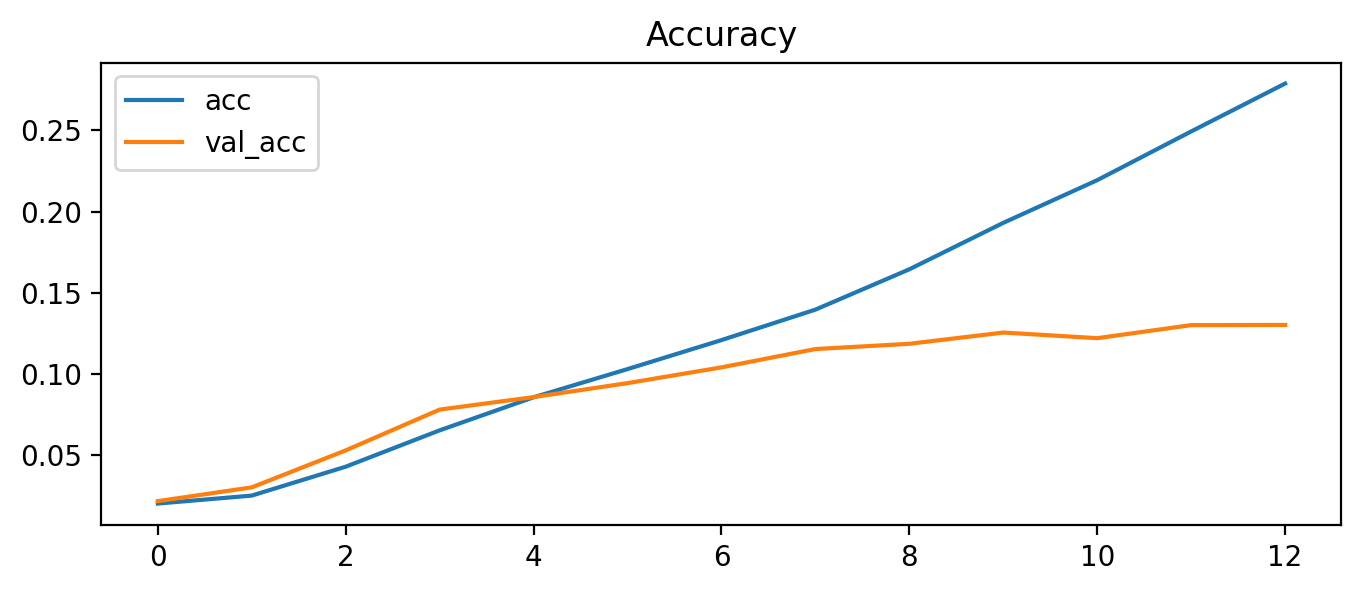

281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.1154 - loss: 5.1963
Eval (loss, acc): [5.196296215057373, 0.11537603288888931]


In [ ]:
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history.history.get('accuracy', []), label='acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Aquí se usa el conjunto de validación
eval_res = model.evaluate(X_val, y_val, verbose=1)
print("Eval (loss, acc):", eval_res)


> FALTA análisis pa saber que tan bien está el modelo

---

**USO DEL MODELO:**

Se encuentra en [app/main.ipynb](app\main.ipynb)